In [4]:
import numpy as np
import pandas as pd
import qinfer as qi
from functools import partial
import matplotlib.pyplot as plt
from sklearn import cluster as sk_cluster
from datetime import date
import time, os

%matplotlib inline
%run mfl_sensing_simplelib.py

print('[{}] Hi, jupyter ready. working dir: {}'.format(time.ctime(), os.getcwd()))


[Fri Sep 25 11:32:21 2020] Hi, jupyter ready. working dir: C:\Users\Timo\OneDrive\_Promotion\Software\MFL_repo


# Preliminaries for the run

## Common parameters

In [5]:
%run mfl_sensing_simplelib.py

def set_common_params():
    global true_omega_1, true_omega_2, freq_min, freq_max, prior
    global t2star_s, true_params, n_particles
    global mfl_res_a, mfl_res_th
    global noise_mode, noise_c, noise_n_rep, noise_phot_0, noise_phot_1
    global binarize_mode
    global exp_mode, hahn_b_gauss
    global run_clustered

    true_omega_1 =  2*np.pi*0.45 #2*np.pi*0.45   # MHz rad, Andrea: 0.33
    true_omega_2 =  2*np.pi*2# 0.54 #2pi*1.6, #0.54 #2*np.pi*1.6   # MHz rad; Andrea: 0.71

    # the frequency boundaries for the starting prior
    freq_min = 0
    freq_max = 2*np.pi*5 # MHz rad
 
    t2star_s = 10e-6  # s
    true_params = np.array([[true_omega_1, true_omega_2]])

    # mfl params
    n_particles = 2000
    mfl_res_a = 0.98
    mfl_res_th = 0.5
    run_clustered = False

    # noise
    noise_mode = None
    noise_c = 0.03
    noise_n_rep = 1e3
    noise_phot_0 = 0.04
    noise_phot_1 = 0.032
    
    # binarization
    binarize_mode = 'majority'  #'rand_coin'
    
    # different pulsed experiments
    exp_mode = 'ramsey'
    hahn_b_gauss = 10

set_common_params()


## MFL Lib

In [44]:
%run mfl_sensing_simplelib.py

def reset_result():
    global track_eval, track_cov, track_cov_full, track_tau, track_loss, track_priors, track_errors, track_z, track_part
    global track_cluster, track_cluster_score
    global prior, model, updater, from_heuristic
    global mfl_res_a, mfl_res_th
    global safe_settings
    
    track_eval = [] # MHz rad
    track_cov = []  # MHz rad
    track_cov_full = []
    track_tau = []  # ns
    track_z = [] # elements: (noisy val, real val, is_error, noisy binarized val, real binarized val)
    track_priors = [] # elements: (prior_as_array, idx_epoch)
    track_loss = []
    track_part = [] # elements: (particle_locations, particle weights)
    track_cluster = [] # elements: ([cluster_peaks (2d)], [cov (2d)], was_focus_invoked)
    track_cluster_score = [] # elements: dict('score1': val, ...)
    
    safe_settings = {'safe_enabled': False}
    #model = ExpDecoKnownPrecessionModel(min_freq= freq_min, invT2= 1/(t2star_s*1e6))
    # resetting updater&heuristic for ease of multiple calls to this cell
    #updater = basic_SMCUpdater(model, n_particles, prior, resample_a=mfl_res_a, resample_thresh=mfl_res_th)
    #updater.reset()
    #heuristic = stdPGH(updater, inv_field='w_')

def get_params():
    global mfl_res_a, mfl_res_th
    global true_omega_1, true_omega_2, freq_min, freq_max, prior
    global t2star_s, true_params, n_particles
    global noise_mode, noise_c, noise_n_rep, noise_phot_0, noise_phot_1
    global binarize_mode, run_clustered
    
   
    
    ret_dict = {'mfl_res_a': mfl_res_a, 'mfl_res_th':mfl_res_th,
               'true_omega_1': true_omega_1, 'true_omega_2': true_omega_2, 'freq_min': freq_min,'freq_max': freq_max,
                't2star_s': t2star_s, 'n_particles':n_particles,
                'noise_mode': noise_mode, 'noise_c': noise_c, 'noise_n_rep': noise_n_rep,
                'noise_photons_0': noise_phot_0, 'noise_photons_1': noise_phot_1,
                'binarize_mode': binarize_mode,
                'exp_mode': exp_mode, 'hahn_b_gauss': hahn_b_gauss, 'clusered':run_clustered}

    
    return ret_dict

def enable_safe(savepath):
    import os
    
    safe_settings['safe_enabled'] = True
    safe_settings['savepath'] = savepath
    
    if not os.path.exists(savepath):
        os.mkdir(savepath)
    
    
    print("Save enabled to {}".format(savepath))

def get_safe_enabled():
    if safe_settings['safe_enabled']:
        return safe_settings['safe_enabled'], safe_settings['savepath'] 
    else:
        return (False, "")

def save_notebook(dir_global_scope):
    import shelve
    import pickle
    
    accept_types = [np.ndarray, str, bool, float, int, list, tuple]
    def to_dict(obj):
        mdict = {}
        accept_types = [np.ndarray, str, bool, float, int, list, tuple]

        if type(obj) is dict:
            d = obj
        else: # convert generic object to dict
            d = obj.__dict__

        for key, var in d.items():
            if type(var) in accept_types:
                mdict[key] = var
            # clear up subdicts from non accepted types
            if type(var) is dict:
                #print("Debug: to dict of:{} ".format(key))
                mdict[key] = to_dict(var)
        
        return mdict
    

    
    if safe_settings['safe_enabled'] == True:
        
        save_notebook_html()
        
        # save all globals and code to shelve file
        filename = safe_settings['savepath'] + '/' + 'nb_vars.shelve'
        my_shelf = shelve.open(filename,'n') 
        for key in dir_global_scope:
            try:
                if type(globals()[key]) in accept_types:
                    my_shelf[key] = globals()[key]
            except TypeError:
                pass
                # __builtins__, my_shelf, and imported modules can not be shelved
                #print('ERROR shelving: {0}'.format(key))
        my_shelf.close()
        
        # all variables to text json file
        import json
        filename = safe_settings['savepath'] + '/' + 'nb_vars.json'
        
        save_dict = {}
        for key in dir_global_scope:
            # need to filter out weird ipython internals
            if key.startswith('_i') or key.startswith('_oh') or key.startswith('_') or key is 'Out' or key is 'In':
                continue
            try:
                save_dict[key] = globals()[key]
            except TypeError:
                pass
        
        #print(save_dict.keys())
        save_dict_2 = to_dict(save_dict)
        
        def save_obj_as_txt(obj, fname):
            # not really human readable, similar to json
            with open(fname + '.pkl', 'wb') as f:
                pickle.dump(obj, f, 0) # protocol 0 is text
        #print("After: {}".format(save_dict_2.keys()))
        
        def convert_ndarray(obj):
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            raise TypeError('Not serializable')
        
        with open(filename, 'w') as file:
            file.write(json.dumps(save_dict_2, default=convert_ndarray, indent=2))
         
        # not really human readable, similar to json
        #save_obj_as_txt(save_dict_2, safe_settings['savepath'] + '/' + 'nb_vars')
            

def DEBUG_rand_z():
    import random
    return random.randint(0,1)

def plot_current_prior(label=None):
    #global prior, model, updater, from_heuristic
    # all particles
    #x = np.asarray(updater.particle_locations)
    #y = np.asarray(updater.particle_weights)
    #plt.scatter(x, updater.particle_weights, label=label)
    #plt.ylim(0, np.max(updater.particle_weights))
    #plt.legend()
    #plt.show()
    
    prior_arr = get_current_prior()
    plot_hist(prior_arr, label=label)

def plot_hist(data, label=None, n_bins=15, color=None):
    plt.hist(data, label=label, bins=n_bins, color=color)
    plt.legend()

    
def get_current_prior():
    global prior, model, updater, from_heuristic
    return updater.sample(n=updater.n_particles)

def binarize_result(z, **kwargs):
    if 'mode' in kwargs:
        mode = kwargs['mode']
        del kwargs['mode']
    else:
        mode = None
    if mode is None:
        mode = 'majority'
    
    # some noise models (eg Gaussian) may return non normed z
    if z<0:
        z = 0
    if z>1:
        z = 1
    
    if mode == 'majority':
        return majority_vote(z, **kwargs)
    elif mode == 'rand_coin':
        coin_res = rand_coin(z)  # balanced coin flip
        return coin_res

    else:
        raise AttributeError("Unknown binarize mode: {}".format(mode))

def majority_vote(z, z_thresh=0.5):
    if z > z_thresh:
        return 1
    else:
        return 0

def rand_coin(z):
    # majority vote randomized by a poissonian distribution
    coin_res = np.random.binomial(1, z)
    return coin_res
    
def exp_result(model, true_params, experiment, n_sweeps=1):
    res_list = []
    # todo: n_sweeps like this shouldn't make any difference for ideal case!
    if n_sweeps > 1:
        raise RuntimeError("Shouldn't use this anymore. No difference for ideal case. Noise handled differently!")
    for i in range(0, n_sweeps):
        res_no_noise = []
        res_list.append(model.simulate_experiment(true_params, experiment, full_result=True))
        z_real = res_list[-1]
    
    avg = np.average(np.asarray(res_list))
    #print("debug: ramsey: average {} of n_sweeps= {}".format(avg, n_sweeps))
    return avg, z_real

def build_simulation_model():
    global noise_mode
    global t2star_s, freq_min
    global exp_mode
    global noise_n_rep, noise_c
    
    if t2star_s != 0.:
        inv_T2 = 1/(1e6*t2star_s)
    else:
        inv_T2 = 0
    
    
    if exp_mode is 'ramsey':
        if noise_mode is None:
            if t2star_s != 0:
                model = ExpDecoKnownMultimodePrecModel(min_freq=0, inv_T2=inv_T2)
            else:
                model = MultimodePrecModel(min_freq=0)
        elif noise_mode == 'Gauss':
            model = NoisyGaussianExpDecoKnownMultimodePrecModel(min_freq=0, inv_T2=inv_T2, c_eff=noise_c, n_rep=noise_n_rep)
        else:
            raise RuntimeError("Invalid noise mode: {}".format(noise_mode))
    elif exp_mode is 'hahn':
        model = MultimodeHahnModel(b_gauss=hahn_b_gauss)
        if noise_mode is not None:
            print("Warning: noise mode {} not implemented. Continuing without noise.".format(noise_mode))
    else:
        raise ValueError("Unknown experiment: {}".format(exp_mode))
    
    return model

def build_initial_prior():
    #guess_init = [freq_max/2, freq_max/2]
    #guess_init = [2*np.pi*1.5, 2*np.pi*1.5]
    #guess_init_cov = [[freq_max/2,0],[0,freq_max/2]]
    #prior = qi.MultivariateNormalDistribution(guess_init, guess_init_cov)
    prior = qi.UniformDistribution(np.asarray([[freq_min, freq_max],[freq_min, freq_max]]))
    
    #print("DEBUG: Initial guess {} +- {} MHz".format(np.asarray(guess_init)/(2*np.pi), np.asarray(guess_init_cov)/(2*np.pi)))    
   
    
    return prior

def eval_loss(
        model, est_mean, true_mps=None,
        true_model=None, true_prior=None
    ):
    
    if true_model is None:
        true_model = model

    if true_mps is None:
        true_mps = true_model.update_timestep(
            promote_dims_left(true_mps, 2), expparams)[:, :, 0]

    if model.n_modelparams != true_model.n_modelparams:
        raise RuntimeError("The number of Parameters in True and Simulated model are different.")
                           
    n_pars = model.n_modelparams

    delta = np.subtract(*qi.perf_testing.shorten_right(est_mean, true_mps))
    loss = np.dot(delta**2, model.Q[-n_pars:])

    return loss

def run_estimation(n_epochs=25, n_sweeps=1):
    global prior, model, updater, from_heuristic
    global noise_mode, noise_c, noise_n_rep, noise_phot_0, noise_phot_1
    global true_params
       
    # the expected T2*, when 0 this is the ideal case
    if t2star_s != 0.:
        inv_T2 = 1/(1e6*t2star_s)
    else:
        inv_T2 = 0
    
    prior = build_initial_prior()
    model = build_simulation_model()
    
    # resetting updater&heuristic for ease of multiple calls to this cell
    updater = qi.SMCUpdater(model, n_particles, prior, resample_thresh=mfl_res_th, resample_a=mfl_res_a)
    #print("Debug res_th {}, res_a {}".format(mfl_res_th, mfl_res_a))
    

    if t2star_s != 0:
        heuristic = T2RandPenalty_MultiPGH(updater, tau_thresh_rescale=t2star_s/4, scale_f=4, inv_field=['w1','w2'])
    else:
        heuristic = MultiPGH(updater, inv_field=['w1','w2'])

    #print("DEBUG: Starting to run UNCLUSTERD with: {}, {}, {}, {}".format(prior, model, updater, heuristic))
    
    for idx_epoch in range(n_epochs):
        #  we call the heuristic to generate a time
        experiment = heuristic()
        tau = experiment['t']

        track_priors.append((get_current_prior(), idx_epoch))
         
        # result as sig_z with and w/o noise
        datum, datum_no_noise = exp_result(model, true_params, experiment, n_sweeps=n_sweeps)
        datum_bin, datum_no_noise_bin = binarize_result(datum, mode=binarize_mode), binarize_result(datum_no_noise, mode=binarize_mode)
        is_error = (datum_bin != datum_no_noise_bin)
        track_z.append([datum, datum_no_noise, is_error, datum_bin, datum_no_noise_bin])
          
        # we invoke the updater method to update the estimate according to the last datum and time chosen
        #experiment['w_'] = 0 # debug: 2nd element needed?
        updater.update(datum_bin, experiment)
        
        particles = [updater.particle_locations, updater.particle_weights]
        prior_erase_mirrored(updater)
            
        # here we just append our latest estimate and error estimate to the list of estimates
        track_tau.append(tau*1e3) # us -> ns
        new_eval = updater.est_mean()
        track_eval.append(new_eval)  # MHz rad
        track_cov.append( np.sqrt( abs(np.nan_to_num(updater.est_covariance_mtx()))))  # actually: std dev, off diagonals abs()
        track_cov_full.append(updater.est_covariance_mtx())
        track_loss.append(eval_loss(model, new_eval, true_params)[0])
        track_part.append([updater.particle_locations, updater.particle_weights])
            
    return (track_tau, track_eval, track_cov, track_priors)


    
def run_estimation_cluster(n_epochs=25, n_sweeps=1, i_split_exp=50, recur_cluster=None):
    
    global prior, model, updater, from_heuristic
    global noise_mode, noise_c, noise_n_rep, noise_phot_0, noise_phot_1
    global true_params
    
    # the expected T2*, when 0 this is the ideal case
    if t2star_s != 0.:
        inv_T2 = 1/(1e6*t2star_s)
    else:
        inv_T2 = 0
    
    prior = build_initial_prior()
    model = build_simulation_model()
    
    # resetting updater&heuristic for ease of multiple calls to this cell
    updater = qi.SMCUpdater(model, n_particles, prior, resample_thresh=mfl_res_th, resample_a=mfl_res_a)
    

    if t2star_s != 0:
        heuristic = T2RandPenalty_MultiPGH(updater, tau_thresh_rescale=t2star_s/4, scale_f=4, inv_field=['w1','w2'],                                        )
    else:
        heuristic = MultiPGH(updater, inv_field=['w1','w2'])
    
    #print("DEBUG: Starting to run with: {}, {}, {}, {}".format(prior, model, updater, heuristic))
    
    for idx_epoch in range(n_epochs):
        #  we call the heuristic to generate a time
        experiment = heuristic()
        tau = experiment['t']
        
        track_priors.append((get_current_prior(), idx_epoch))
         
        # result as sig_z with and w/o noise
        datum, datum_no_noise = exp_result(model, true_params, experiment, n_sweeps=n_sweeps)
        datum_bin, datum_no_noise_bin = binarize_result(datum, mode=binarize_mode), binarize_result(datum_no_noise, mode=binarize_mode)
        is_error = (datum_bin != datum_no_noise_bin)
        track_z.append([datum, datum_no_noise, is_error, datum_bin, datum_no_noise_bin])
          
        # we invoke the updater method to update the estimate according to the last datum and time chosen
        #experiment['w_'] = 0
        updater.update(datum_bin, experiment)
            
        particles = [updater.particle_locations, updater.particle_weights]
        #prior_erase_mirrored(updater)
        prior_erase_negative(updater)
        
        peaks, cov, score = cluster_2d(particles)
        was_focus_invoked = False
        #if _start_clustering(idx_epoch, i_split_exp, recur_cluster):
        if _auto_clusterstart(idx_epoch - 1, req_mirrored_detect=True):    
            updater, _ = focus_single_cluster(peaks, cov)
            heuristic = T2RandPenalty_MultiPGH(updater, tau_thresh_rescale=t2star_s/4, scale_f=4, inv_field=['w1','w2'],
                                               )
            was_focus_invoked = True
            #print("Invoked clustering at epoch {}. Clustered peaks {} MHz +- {} MHz".format(
            #    idx_epoch, np.asarray(peaks)/(2*np.pi), np.sqrt(np.asarray(cov))))
            
        # here we just append our latest estimate and error estimate to the list of estimates
        track_tau.append(tau*1e3) # us -> ns
        new_eval = updater.est_mean()
        track_eval.append(new_eval)  # MHz rad
        track_cov.append( np.sqrt( abs(np.nan_to_num(updater.est_covariance_mtx()))))  # actually: std dev, off diagonals abs()
        track_cov_full.append(updater.est_covariance_mtx())
        track_loss.append(eval_loss(model, new_eval, true_params)[0])
        track_part.append(particles)
        track_cluster.append([peaks, cov, was_focus_invoked])
        track_cluster_score.append(score)
            
    return (track_tau, track_eval, track_cov, track_priors)

def _auto_clusterstart(idx_epoch, req_mirrored_detect=True, thresh_dbi=0.5):
    
    idx_epoch = int(idx_epoch)
    
    if idx_epoch < 0:
        return False
    
    dist_mirr = [np.mean(dist_list)/(2*np.pi) for dist_list in get_dist_cluster_to_mirrored()]
    cluster_std = [np.sqrt(np.asanyarray(row[1])) for row in track_cluster]
    std_sum = [np.sum(np.asarray(std))/(2*np.pi) for std in cluster_std]
  
    score_ch = [dict_score['calinski_harabasz'] for dict_score in track_cluster_score]
    score_dbi = [dict_score['davies_bouldin'] for dict_score in track_cluster_score]
    score_s = [dict_score['silhouette'] for dict_score in track_cluster_score]
    
    if req_mirrored_detect:
        mirrored_detected = dist_mirr[idx_epoch] < std_sum[idx_epoch]
    else:
        mirrored_detected = True
    
    if mirrored_detected and score_dbi[idx_epoch]/max(score_dbi) < thresh_dbi:
        return True
    
    return False

def _start_clustering(i_epoch, i_split_exp, recur_cluster):
        check_condition = False
        if recur_cluster is None:
            if i_epoch == i_split_exp:
                check_condition = True
        else:
            if i_epoch >= i_split_exp and i_epoch%recur_cluster ==0:   
                check_condition = True     
                
        return check_condition

def cluster_1d(particles, n_clusters=2):
    particles_kmeans = particles[0][:,0][:, np.newaxis]  # reshape locartions
    result_KM = sk_cluster.KMeans(n_clusters=n_clusters).fit(particles_kmeans)
    
    cov_peaks = []
    loc_peaks = []

    for cluster_peak in range(n_clusters):
        clust_particles = particles_kmeans[np.where(result_KM.labels_ == cluster_peak)] 
        loc_peaks.append(result_KM.cluster_centers_[cluster_peak])
        cov_peaks.append((np.std(clust_particles.flatten())/2)**2)
    
    return loc_peaks, cov_peaks

def cluster_2d(particles, n_clusters=2):
    particles_kmeans = particles[0]
    result_KM = sk_cluster.KMeans(n_clusters=n_clusters).fit(particles_kmeans)
    
    cov_peaks = []
    loc_peaks = []

    for cluster_peak in range(n_clusters):
        clust_particles = particles_kmeans[np.where(result_KM.labels_ == cluster_peak)] 
        loc_peaks.append(result_KM.cluster_centers_[cluster_peak])
        cov_matrix = np.cov(np.transpose(clust_particles))
         # simplify to mean variance (circle) of every cluster center
        cov_peaks.append(np.sqrt(cov_matrix[0,0]**2 + cov_matrix[1,1]**2))   
    
    # compute metrics
    from sklearn import metrics
    labels = result_KM.labels_
    score_ch = metrics.calinski_harabasz_score(particles_kmeans, labels) 
    score_dbi = metrics.davies_bouldin_score(particles_kmeans, labels) 
    score_s =  metrics.silhouette_score(particles_kmeans, labels) 
    
    score_dict = {'calinski_harabasz': score_ch,
                 'davies_bouldin': score_dbi,
                 'silhouette': score_s}
    
    return loc_peaks, cov_peaks, score_dict

def prior_erase_mirrored(updater):
    #particles = [updater.particle_locations, updater.particle_weights]
    # by definition w2 > w1
    
    updater.particle_weights[updater.particle_locations[:,1] < updater.particle_locations[:,0]] = 0
    #print(particles[0])
    #print(particles[1])
    
    
def prior_erase_negative(update):
    updater.particle_weights[updater.particle_locations[:,1] < 0] = 0
    updater.particle_weights[updater.particle_locations[:,0] < 0] = 0
    
def focus_single_cluster(cluster_peaks, cov_list):
    
    global updater, model, n_particles
    
    # little bit cheating (for convencience only)
    # choose cluster that is closer to true params    
    dist = np.linalg.norm(true_params)
    for i, p in enumerate(cluster_peaks):
        dist_i = np.linalg.norm(p - true_params)
        if dist_i < dist:
            real_peak = p
            real_cov = cov_list[i]
            dist = dist_i
    
    prior = qi.MultivariateNormalDistribution(real_peak, [[real_cov, 0], [0, real_cov]])
    ignored_updater = copy.deepcopy(updater)      # the updater just before the split is discarded
    # focus on single peak
    updater = qi.SMCUpdater(model, n_particles, prior)
    
    return updater, ignored_updater


def get_likelihood(idx_epoch, omega_mhzrad_1, omega_mhzrad_2, exp_outcome=0):
    global model, updater
    
    locs = np.zeros([len(omega_mhzrad_1), 2]) #updater.particle_locations
    locs[:, 0] = omega_mhzrad_1
    locs[:, 1] = omega_mhzrad_2
    
    expparams = np.empty((1,), dtype=[('t', '<f8'), ('w1', '<f8'), ('w2', '<f8')])  # tau (us)
    expparams['t'] = track_tau[idx_epoch]*1e-3
    expparams['w1'] = 0
    expparams['w2'] = 0
    
    y = model.likelihood(exp_outcome, locs, expparams).transpose([0, 2, 1]).transpose()[:,0,0]
    
    #plt.scatter(locs, y)
    #plt.show()
    
    return locs/(2*np.pi), y    # MHz   
       

    
def plot_result():
    #print(track_eval[-1], track_cov[-1])
    
    # est(B), dB
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    x = range(0, len(track_eval))
    y_1 = np.asarray([val[0] for val in track_eval])/(2.*np.pi)
    y_2 = np.asarray([val[1] for val in track_eval])/(2.*np.pi)
    dy_1 = np.asarray([el[0][0] for el in track_cov])/(2*np.pi)
    dy_2 = np.asarray([el[1][1] for el in track_cov])/(2*np.pi)
    plt.plot(y_1, label='est(B)= {:.4f} MHz'.format(y_1[-1]))
    plt.plot(y_2, label='est(B)= {:.4f} MHz'.format(y_2[-1]), color='orange')
    plt.fill_between(x, y_1-dy_1, y_1+dy_1, alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF', antialiased=True)
    plt.fill_between(x, y_2-dy_2, y_2+dy_2, alpha=0.2, edgecolor='red', facecolor='yellow', antialiased=True)
    #plt.plot(dy, label='dB')
    plt.axhline(y=true_omega_1/(2*np.pi), label="B_1= {:.2f} MHz".format(true_omega_1/(2*np.pi)))
    plt.axhline(y=true_omega_2/(2*np.pi), label="B_2= {:.2f} MHz".format(true_omega_2/(2*np.pi)), color='orange')
    plt.legend()
    axes = plt.gca()
    axes.set_ylabel('B*gamma / dB (MHz)')
    
    plt.subplot(122)
    y_ql = (y_1 - true_omega_1/(2. * np.pi))**2
    y_q2 = (y_2 - true_omega_2/(2. * np.pi))**2
    plt.plot(y_ql)
    plt.plot(y_q2, color='orange')
    
    axes = plt.gca()
    axes.set_ylabel('quadratic losses (MHz^2)')
    axes.set_yscale('log')
    
    is_safe, path = get_safe_enabled()
    fname = path +'/' + 'mfl_result.png'
    if is_safe:
        plt.savefig(fname)
    plt.show()

    
def plot_scaling(taus=None, dB_mhz=None, n_rep=1,
                 taus_scatter=None, dB_mhz_scatter=None, ddB1=None, ddB2=None):
    #print(track_eval[-1], track_cov[-1])
    
    if taus is None:
        taus = np.asarray(track_tau)*1e-9
    else:
        taus = taus
        
    x = range(0, len(taus))
    if dB_mhz is None:
        dy = np.asarray([el[0][:] for el in track_cov])/(2*np.pi)
    else:
        dy = dB_mhz
        
    taus = taus * n_rep
    tau_tot = calc_total_runtime(taus)
    if taus_scatter is not None:
        taus_tot_scatter = np.asarray([calc_total_runtime(run*n_rep) for run in taus_scatter]).flatten()
   
    # est(B), dB
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    if taus_scatter is not None and dB_mhz_scatter is not None:
        dB1_mhz_scatter = dB_mhz_scatter[:,0,:]
        dB2_mhz_scatter = dB_mhz_scatter[:,1,:]
        plt.scatter(taus_tot_scatter, dB1_mhz_scatter, s=3, marker='o', facecolors='none', alpha=0.1, edgecolors='b')
        plt.scatter(taus_tot_scatter, dB2_mhz_scatter, s=3, marker='o', facecolors='none', alpha=0.1, edgecolors='r')
    
    plt.plot(tau_tot, dy[:,0])
    plt.plot(tau_tot, dy[:,1])
    if ddB1 is not None:
        plt.fill_between(tau_tot, dy[:,0]-ddB1, dy[:,0]+ddB1, alpha=0.2, edgecolor='#1B2ACC', facecolor='blue',
                     antialiased=True)
    if ddB2 is not None:
        plt.fill_between(tau_tot, dy[:,1]-ddB2, dy[:,1]+ddB2, alpha=0.2, edgecolor='#1B2ACC', facecolor='orange',
                     antialiased=True)
    
    #plt.fill_between(x, y-dy, y+dy, alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    #                 antialiased=True)
    #plt.plot(dy, label='dB')
    #plt.axhline(y=true_omega/(2*np.pi), label="B= {:.4f} MHz".format(true_omega/(2*np.pi)))
    
    # fit to tail 
    n_epochs = len(x)
    n_points_fit = int(n_epochs/10)
    
    tau_log = np.log10(tau_tot)
    y_log = np.log10(dy[:,0])
    
    coefficients = np.polyfit(tau_log[-n_points_fit:], y_log[-n_points_fit:], 1)
    #print("DEBUG: n_epcohs, n_points_fit: {}, {}".format(n_epochs, n_points_fit))
    #print("DEBUG: tau_log, y_log: {}, {}".format(tau_log, y_log))
    #print("DEBUG: fit result: {}".format(coefficients))
    
    polynomial = np.poly1d(coefficients)
    ys = 10**polynomial(tau_log)
    n_plot_fit = int(0.95*len(tau_tot))
    plt.plot(tau_tot[-n_plot_fit:], ys[-n_plot_fit:], alpha=0.4,
             label='{:.2f} t + {:.2f}'.format(coefficients[0],coefficients[1]))
    
    plt.legend()
    axes = plt.gca()
    axes.set_xscale('log')
    axes.set_xlabel(r'$t_{\Phi,tot}$ (s)')
    axes.set_yscale('log')
    axes.set_ylabel('dB (MHz)')
    
    plt.subplot(122)
    
    #dB_nT = np.sqrt(dy[:,0]**2 + dy[:,1]**2)/(2.8*1e4)*1e9
    dB_nT= (dy[:,0] + dy[:,1])/(2*2.8*1e4)*1e9
    eta_phase_nT = np.sqrt(tau_tot)*dB_nT
   
    eta_phase_mean = np.average(eta_phase_nT[-n_points_fit:])
    if taus_scatter is not None and dB_mhz_scatter is not None:
        eta_scatter = np.sqrt(taus_tot_scatter)*(dB1_mhz_scatter.flatten()+dB2_mhz_scatter.flatten())/(2*2.8*1e4)*1e9
    
    if taus_scatter is not None and dB_mhz_scatter is not None:
        plt.scatter(taus_tot_scatter, eta_scatter, s=3, marker='o', facecolors='none', edgecolors='r', alpha=0.1)
        #print(taus_tot_scatter)
    
    if ddB1 is not None and ddB2 is not None:
        d_eta = np.sqrt(tau_tot)*(ddB1 + ddB2)/(2*2.8*1e4)*1e9 
        plt.fill_between(tau_tot, eta_phase_nT-d_eta, eta_phase_nT+d_eta, alpha=0.2, edgecolor='#1B2ACC', facecolor='blue',
                     antialiased=True)
        
    plt.plot(tau_tot,eta_phase_nT)
    plt.axhline(eta_phase_mean, label="avg= {:.4f} nT/sqrt(Hz)".format(eta_phase_mean))
    
   
 
    plt.legend()
    axes = plt.gca()
    axes.set_xscale('log')
    axes.set_xlabel(r'$t_{\Phi,tot}$(s)')
    axes.set_yscale('log')
    axes.set_ylabel(r'$\eta_{avg}$ (nT/sqrt(Hz))')
    plt.title("n_rep= {}".format(n_rep))
    if taus_scatter is not None:
        plt.xlim([0.9*np.min(taus_tot_scatter),1.1*np.max(taus_tot_scatter)])
        plt.ylim([0.9*np.min(eta_phase_nT),1.1*np.max(eta_phase_nT)])
    
    plt.tight_layout()
    plt.show()
    
    
def plot_zs():
    global true_omega, binarize_mode
    global track_tau, track_z
    
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    
    tau_max = 1e-3*max(track_tau)[0]  # ns -> us
    t = np.linspace(0, tau_max, 100)
    
    # prepae input for likelihood
    expparams = np.zeros((len(t),), dtype=model.expparams_dtype)
    expparams['t'] = t
    modelparams = np.zeros((1,2))
    modelparams[0,0] = true_omega_1
    modelparams[0,1] = true_omega_2
    
    y_ideal = model.likelihood(None, modelparams, expparams)[0,0,:]
    #y_ideal = 1 - 0.5 * (np.cos(t * true_omega_1 / 2) ** 2 + np.cos(t * true_omega_2 / 2) ** 2)
    plt.plot(t, y_ideal, label="Ramsey {:.1f} / {:.1f} MHz".format(
        true_omega_1/(2*np.pi), true_omega_2/(2*np.pi)))
    
    tau_corr_us = []
    tau_err_us = []
    z_bin_corr = []
    z_bin_err = []
    z_corr = []
    z_err = []
    z_err_corrected = []  # actually correct value
    z = [el[0] for el in track_z]
    tau = np.asarray(track_tau) *1e-3  # ns -> us
 

    for i, tau_i in enumerate(tau): 

        track_z_i = track_z[i]
        if track_z_i[2]: # is_error
            z_bin_err.append(track_z_i[3])
            tau_err_us.append(tau_i)
            z_err.append(track_z_i[0])
            z_err_corrected.append(track_z_i[1])
        else:
            z_bin_corr.append(track_z_i[3])
            tau_corr_us.append(tau_i)
            z_corr.append(track_z_i[0])
    
    print("DEBUG: len z_err {}, z_corr {}".format(len(z_err), len(z_corr)))
    no_scatter = False
    if not no_scatter:
        plt.scatter(tau_err_us, z_err, label="sig_z wrong", color='red')
        plt.scatter(tau_corr_us, z_corr, label="sig_z")
        plt.scatter(tau_corr_us, z_bin_corr, label="z_bin", marker='s', s=12, alpha=0.8)
        plt.scatter(tau_err_us, z_bin_err, label="z_bin wrong", color='red', marker='s', s=12, alpha=0.8)
    plt.ylim([-0.2,1.2])
    plt.xlabel("tau (us)")
    plt.title("Binarize mode: {}".format(binarize_mode))
    
    plt.legend(bbox_to_anchor=(1, 0.8, 1, 0.2), loc="upper left", ncol=1)
    #plt.show()
    
    # histogram of wrong z
    plt.subplot(122)
    plt.hist(z_err_corrected, bins=15, color='orange')
    plt.ylabel("Error votes")
    plt.xlabel("sig_z_correct")
    plt.xlim([0,1])
    
    is_safe, path = get_safe_enabled()
    fname = path + '/' + 'mfl_zs.png'
    if is_safe:
        plt.savefig(fname)
        
    plt.tight_layout()        
    plt.show()
    
    #track_z
def plot_priors_2d_gaussian(epochs_idx=[]):
    global updater
    global track_part
    
    save_updater_locs, save_udpater_weights = updater.particle_locations, updater.particle_weights
    
    n_rows, n_col = _get_prior_plotsize(epochs_idx, always_show_err=False, n_col=2)
    plt.figure(figsize=(12, n_rows*4))
    
    idx_plot = 0
    for i, p in enumerate(track_part):
        epoch = i
        if epoch in epochs_idx:
            updater.particle_locations = track_part[epoch][0]
            updater.particle_weights = track_part[epoch][1]
            
            plt.subplot(n_rows, n_col, idx_plot+1)
            line = updater.plot_posterior_contour()
            ax = plt.gca()
            
            label='Prior countour epoch {}'.format(epoch)
            plt.title(label)
            plt.xlabel("$\omega_1$ (MHz rad)")
            plt.ylabel("$\omega_2$ (MHz rad)")
            
            idx_plot += 1
        
    # reset
    updater.particle_locations, updater.particle_weights = save_updater_locs, save_udpater_weights
    
    plt.legend()
    
    is_safe, path = get_safe_enabled()
    fname = path + '/' + 'mfl_priors_2d.png'
    if is_safe:
        plt.savefig(fname)
            
    plt.show()
    
def plot_priors_2d_gaussian_heatmap(epochs_idx=[], n_bins=50, plot_likelihoods=False):
    global updater
    global track_part
    
    save_updater_locs, save_udpater_weights = updater.particle_locations, updater.particle_weights
    
    n_rows, n_col = _get_prior_plotsize(epochs_idx, always_show_err=False, n_col=2)
    if plot_likelihoods:
        n_rows *= 2
    plt.figure(figsize=(12, n_rows*4))
    
    idx_plot = 0
    for i, p in enumerate(track_part):
        epoch = i
        if epoch in epochs_idx:
            updater.particle_locations = track_part[epoch][0]
            updater.particle_weights = track_part[epoch][1]
            particle_locations = updater.particle_locations
            
            plt.subplot(n_rows, n_col, idx_plot+1)
            line = plt.hist2d(updater.particle_locations[:,0]/(2*np.pi), updater.particle_locations[:,1]/(2*np.pi),
                              weights=updater.particle_weights, bins=n_bins)

                
            # mark clusters
            try:
                cluster_1 = track_cluster[epoch][0][0]/(2*np.pi)
                cluster_2 = track_cluster[epoch][0][1]/(2*np.pi)
                cov_1 = track_cluster[epoch][1][0]/(2*np.pi)
                cov_2 = track_cluster[epoch][1][1]/(2*np.pi)
                #center1 = plt.Circle(cluster_1, cov_1, color='r', fill=True)
                circle1 = plt.Circle(cluster_1, np.sqrt(cov_1), color='r', fill=False)
                circle2 = plt.Circle(cluster_2, np.sqrt(cov_2), color='r', fill=False)

 
                ax = plt.gca()
                ax.add_artist(circle1)
                ax.add_artist(circle2)
            except:
                pass
            
            label='p(B) epoch {}'.format(epoch)
            plt.title(label)
            plt.xlabel("$\omega_1$ (MHz)")
            
            if idx_plot %  n_col == 0:
                plt.ylabel("$\omega_2$ (MHz)")
            else:
                ax = plt.gca()
                ax.tick_params(labelleft=False) 
            idx_plot += 1
        
            if plot_likelihoods:

                omega_1 = np.linspace(min(particle_locations[:,0]), max(particle_locations[:,0]), 50)
                omega_2 = np.linspace(min(particle_locations[:,1]), max(particle_locations[:,1]), 50)

                x_grid, y_grid = np.meshgrid(omega_1, omega_2)

                z_bin = binarize_result(track_z[epoch][0], mode=binarize_mode)
                x, y = get_likelihood(epoch, x_grid.flatten(), y_grid.flatten(), exp_outcome=z_bin)
                y_2d = y.reshape(len(omega_1), len(omega_2))                   

                plt.subplot(n_rows, n_col, idx_plot+1)
                plt.imshow(y_2d, vmin=0, extent=[omega_1[0]/(2*np.pi), omega_1[-1]/(2*np.pi),
                                                 omega_2[0]/(2*np.pi), omega_2[-1]/(2*np.pi)],
                           cmap='plasma', aspect='auto', origin='lower')

                plt.xlabel("$w_{1}$ (MHz)")
                ax = plt.gca()
                ax.tick_params(labelleft=False) 
                plt.colorbar()
                plt.title("L({:.0f}|B)\ntau= {:.2f} us".format(z_bin, 
                                                                track_tau[epoch][0]*1e-3))

                idx_plot += 1
                
        
    
    # reset
    updater.particle_locations, updater.particle_weights = save_updater_locs, save_udpater_weights
    
    plt.tight_layout()
    plt.legend()
    
    is_safe, path = get_safe_enabled()
    fname = path + '/' + 'mfl_priors_2d_heat.png'
    if is_safe:
        plt.savefig(fname)
            
    plt.show()
            
def _get_prior_plotsize(epochs_idx=[], always_show_err=False, n_col=6):
    plot_all = not epochs_idx 
    epochs_error = [el[0] for el in get_error_zs()]
    n_plots = len(track_priors) if plot_all else len(epochs_idx)
    n_plots += 2*len(epochs_error)
    n_rows = np.ceil(n_plots/n_col) 
    
    return n_rows, n_col
        
def plot_priors(epochs_idx=[], n_bins=15, always_show_err=True):
       
    n_rows, n_col = _get_prior_plotsize(epochs_idx, always_show_err)
    epochs_error = [el[0] for el in get_error_zs()]
    plot_all = not epochs_idx 
    plt.figure(figsize=(12, n_rows*4))
    
    idx_plot = 0
    for i, p in enumerate(track_priors):
        epoch = p[1]
        is_error = epoch in epochs_error or epoch-1 in epochs_error   # see prior after error
        if not always_show_err:
            is_error = False
        color = 'blue' if not is_error else 'red'
        
        if epoch in epochs_idx or plot_all or is_error:
            data_1 = np.asarray([el[0] for el in p[0]])/(2*np.pi)
            data_2 = np.asarray([el[1] for el in p[0]])/(2*np.pi)
            plt.subplot(n_rows, n_col, idx_plot+1)
            plot_hist(data_1, label='Prior epoch {}'.format(epoch), n_bins=n_bins, color=color) 
            plot_hist(data_2, label='Probability'.format(epoch), n_bins=n_bins, color='orange') 
            ax1 = plt.gca()
            plt.legend(bbox_to_anchor=(0, 1.08, 1, 0.2), loc="lower left", ncol=1)
            
            # plot likelihood function that is multiplied

            omega_mhzrad_1 = np.linspace(2*np.pi*min(data_1), 2*np.pi*max(data_1), 200)
            omega_mhzrad_2 = np.linspace(2*np.pi*min(data_2), 2*np.pi*max(data_2), 200)
            z_bin = majority_vote(track_z[epoch][0])
            
            x_mhz, y = get_likelihood(epoch, omega_mhzrad_1, omega_mhzrad_2, exp_outcome=z_bin)
            # todo: broken: have to think about marginal distributions!
            ax2 = ax1.twinx()
            ax2.plot(x_mhz[:,0], y, color='blue', label='L |z={}'.format(z_bin))
            ax2.plot(x_mhz[:,1], y, color='orange', label='L |z={}'.format(z_bin))

    
            plt.xlabel("B (MHz)")
            plt.tight_layout()
            # legend location
            # https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot/43439132#43439132
            plt.legend(bbox_to_anchor=(0, 1.00, 1, 0.2), loc="lower left", ncol=1)
            idx_plot += 1
    
    is_safe, path = get_safe_enabled()
    fname = path +'/' + 'mfl_priors.png'
    if is_safe:
        plt.savefig(fname)
    
    plt.show()
    
def plot_taus(taus=None):
      
    if taus is None:
        taus = np.asarray(track_tau)  # ns
    taus = np.asarray(taus)
    
    x_epochs = range(0, len(taus[0]))

    t2_ns = t2star_s*1e9
    tau_median_ns = np.median(taus)
    frac_bigger_t2 = len(taus[taus>t2_ns])/len(taus)
    frac_bigger_10t2 = len(taus[taus>10*t2_ns])/len(taus)
    taus_filter_ns = taus[taus < 10 *t2_ns]
    
    plt.figure(figsize=(12, 1*4))
    plt.subplot(121)
    for row_rep in taus:
        plt.scatter(x_epochs, row_rep*1e-3, color="blue", s=2)
    plt.legend()

    plt.axhline(y=t2_ns*1e-3, label='T2*= {} us'.format(t2_ns*1e-3), color='red')
    plt.axhline(y=tau_median_ns*1e-3, label='median= {:.1f} us'.format(tau_median_ns*1e-3), color='green')
    axes = plt.gca()
    #axes.set_ylim([0.01,1000])
    axes.set_xlabel('epoch')
    axes.set_ylabel('tau (us)')
    axes.set_yscale('log')
    axes.set_title('frac_bigger_t2= {}, bigger_10*t2= {}'.format(frac_bigger_t2, frac_bigger_10t2))
    plt.legend()
    
    plt.subplot(122)
    plt.hist(taus_filter_ns*1e-3, bins=100)
    axes = plt.gca()
    #axes.set_xlim([0, 2*t2_ns*1e-3])
    axes.set_yscale('log')
    axes.set_xlabel('tau (us)')
    axes.set_ylabel('histogram')
    plt.axvline(tau_median_ns*1e-3, label='median= {:.1f} us'.format(tau_median_ns*1e-3), color='green')
    plt.axvline(x=t2_ns*1e-3, label='T2*= {} us'.format(t2_ns*1e-3), color='red')
    #plt.axvline(t2_ns)
    plt.legend()
    
    #is_safe, path = get_safe_enabled()
    #fname = path +'/' + 'mfl_taus.png'
    #if is_safe:
    #    plt.savefig(fname)
        
    plt.show()

def plot_clusters():
    
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    dist_mirr = [np.mean(dist_list)/(2*np.pi) for dist_list in get_dist_cluster_to_mirrored()]
    x = range(0, len(dist_mirr), 1)
    cluster_std = [np.sqrt(np.asanyarray(row[1])) for row in track_cluster]
    #print(cluster_covs)
    std_sum = [np.sum(np.asarray(std))/(2*np.pi) for std in cluster_std]
    plt.semilogy(x, dist_mirr, label="mean(dist_mirrored)")
    plt.semilogy(x, std_sum, label="sum(std)")
    plt.legend()
    
    plt.subplot(122)
    score_ch = [dict_score['calinski_harabasz'] for dict_score in track_cluster_score]
    score_dbi = [dict_score['davies_bouldin'] for dict_score in track_cluster_score]
    score_s = [dict_score['silhouette'] for dict_score in track_cluster_score]
    plt.plot(x, score_ch/max(score_ch), label="Calinski_Harabasz")
    plt.plot(x, score_dbi/max(score_dbi), label="Davies_Bouldin")
    plt.plot(x, score_s/max(score_s), label="Silhouette")
    plt.legend()
    
    
    is_safe, path = get_safe_enabled()
    fname = path +'/' + 'clusters.png'
    if is_safe:
        plt.savefig(fname)
            
    plt.show()

    
def plot_noise_model(n_samples=1e3, n_bins=15):
    global noise_mode
    model = build_simulation_model()
    
    if noise_mode == 'Gauss':
        plt.title("Gauss noise for 0/1 state. C= {}, n_sweeps= {}".format(model.c_eff, model.n_rep))
        res0 = model.sample(0, n_samples=n_samples)
        res1 = model.sample(1, n_samples=n_samples)
    elif noise_mode == 'Poiss':
        plt.title("Poiss noise for 0/1 state. Photons_0 {}, Photons_1 {}, n_sweeps= {}".format(
            model.cts_0, model.cts_1, noise_n_rep))
        res0 = model.sample(0, n_samples=n_samples, as_photons=False)
        res1 = model.sample(1, n_samples=n_samples, as_photons=False)
        res0_ph = model.sample(0, n_samples=n_samples, as_photons=True)
        res1_ph = model.sample(1, n_samples=n_samples, as_photons=True)
    elif noise_mode is None:
        plt.title("Noise for 0/1 state.")
        res0 = [0]
        res1 = [1]
    else:
        raise NotImplementedError('Unknown noise model: {}'.format(noise_mode))
    
    plt.hist(res0, bins=n_bins, label='0')
    plt.hist(res1, bins=n_bins, label='1')
    plt.xlabel('sig_z')
    plt.hist(np.concatenate([res0, res1]), histtype='step', bins=n_bins)
    plt.axvline(0, color='blue')
    plt.axvline(1, color='orange')
    plt.legend()
    plt.show()
    
    if noise_mode == 'Poiss':
        plt.figure()
        plt.hist(res0_ph, bins=n_bins)
        plt.hist(res1_ph, bins=n_bins)
        plt.hist(np.concatenate([res0_ph, res1_ph]), histtype='step', bins=n_bins)
        plt.show()
        
    is_safe, path = get_safe_enabled()
    fname = path +'/' + 'noise_model.png'
    if is_safe:
        plt.savefig(fname)
    
    
def get_error_zs():
    # [i_epoch, (track_z)]
    return [[i, el[0], el[1], el[2]] for i, el in enumerate(track_z) if el[2]]

def get_dist_cluster_to_mirrored():
    # assumes 1 or 2 clusters in each epoch!
    global track_cluster
    
    dist_list = []
    for i_epoch, row in enumerate(track_cluster):
        peaks = row[0]
        cov = np.asarray(row[1])
        dist_i = []

        for i_p, p in enumerate(peaks):
            if len(peaks) == 1:
                dist_i.append(0.0)
                break
            else:
                p_mirror = list(reversed(p))
                if i_p == 0:
                    p_other = peaks[1]
                elif i_p == 1:
                    p_other = peaks[0]
                else:
                    raise RuntimeError("Found more than 2 cluster peaks: {}".format(len(peaks)))
                dist_i.append(np.linalg.norm(p_mirror - p_other))
        
        dist_list.append(np.asarray(dist_i))
        """
        peaks_0_mhz = np.asarray(peaks[0])/(2*np.pi)
        peaks_1_mhz = np.asarray(peaks[1])/(2*np.pi)
        dist_i_mhz = np.asarray(dist_i)/(2*np.pi)
        #print("Debug: [{}]: p1 {}, p2 {} -> dist {}.".format(i_epoch, peaks_0_mhz, peaks_1_mhz, dist_i_mhz))
        print("Debug: [{}] -> dist {}. Cov: {}".format(i_epoch, np.mean(dist_i_mhz), np.sum(cov)/(2*np.pi)))
        print("Debug: [{}] -> dist < Cov: {}".format(i_epoch, np.mean(dist_i_mhz) < np.sum(cov)/(2*np.pi)))
        """
        
    return dist_list

def get_file_index(path, fname=None, splitchar='.'):
    """
    shadow of mfl_irq_driven.ipynb
    given a filename ("file.xyz"), return the highest unused index in the save path
    """
    
    from pathlib import Path
    
    is_looking_for_folder = False
    if fname is None: 
        is_looking_for_folder = True
        fname = os.path.basename(path)
        path = Path(path).parents[0]
    if is_looking_for_folder:
        idx_split = -1
    else:
        idx_split = -2
    index = 0
    # print(os.path.splitext(fname)[0])
    for file in os.listdir(path):
        if file.startswith(os.path.splitext(fname)[0]):
            if len(file.split(splitchar)) > abs(idx_split):  # filename has at least one 'middle initial'
                try:
                    fi = int(file.split(splitchar)[idx_split])  # try to convert second-last string into integer
                except:
                    continue
                if fi >= index:
                    index = fi + 1
    return index


def calc_total_runtime(t_per_epoch):
    # shadows method qudi/mfl_irq_driven
    t_total = np.zeros(len(t_per_epoch))
    for i, val in enumerate(t_per_epoch):
        if t_per_epoch[i] is np.nan:
            self.log.warning("NaN in array summed up as 0.")
            t_per_epoch[i] = 0
        t_total[i] = np.sum(t_per_epoch[0:i + 1])
        if t_total[i] == 0:
            t_total[i] = np.nan

    return t_total

def get_idx_cluster_focused():
    return [i for i, el in enumerate(track_cluster) if el[2]]


def save_notebook_html():
    from nbconvert import HTMLExporter
    import codecs
    import nbformat

    notebook_name = 'Simulate_multiMFL.ipynb'
    
    filename = safe_settings['savepath'] + '/' + 'Simulate_multiMFL.html'
    filename.replace("\\","//")

    exporter = HTMLExporter()
    output_notebook = nbformat.read(notebook_name, as_version=4)

    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(filename, 'w', encoding='utf-8').write(output)
    
#run_estimation()
#noise_mode = 'Gauss'
#noise_n_rep = 1e3
#noise_c = 0.03
#plot_noise_model()
    

<Figure size 432x288 with 0 Axes>

# Run MFL

{'mfl_res_a': 0.98, 'mfl_res_th': 0.5, 'true_omega_1': 2.827433388230814, 'true_omega_2': 12.566370614359172, 'freq_min': 0, 'freq_max': 31.41592653589793, 't2star_s': 1.9e-05, 'n_particles': 2000, 'noise_mode': None, 'noise_c': 0.0369, 'noise_n_rep': 1500, 'noise_photons_0': 0.04, 'noise_photons_1': 0.032, 'binarize_mode': 'majority', 'exp_mode': 'ramsey', 'hahn_b_gauss': 10, 'clusered': False}


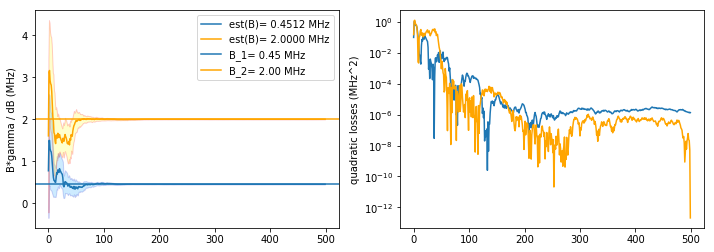

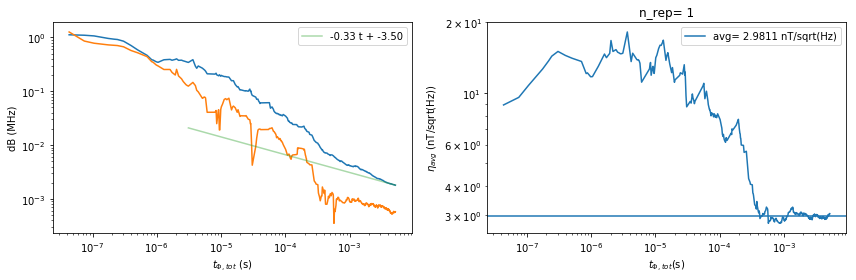

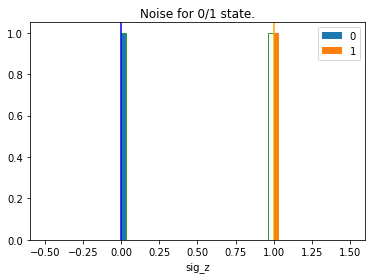

No handles with labels found to put in legend.


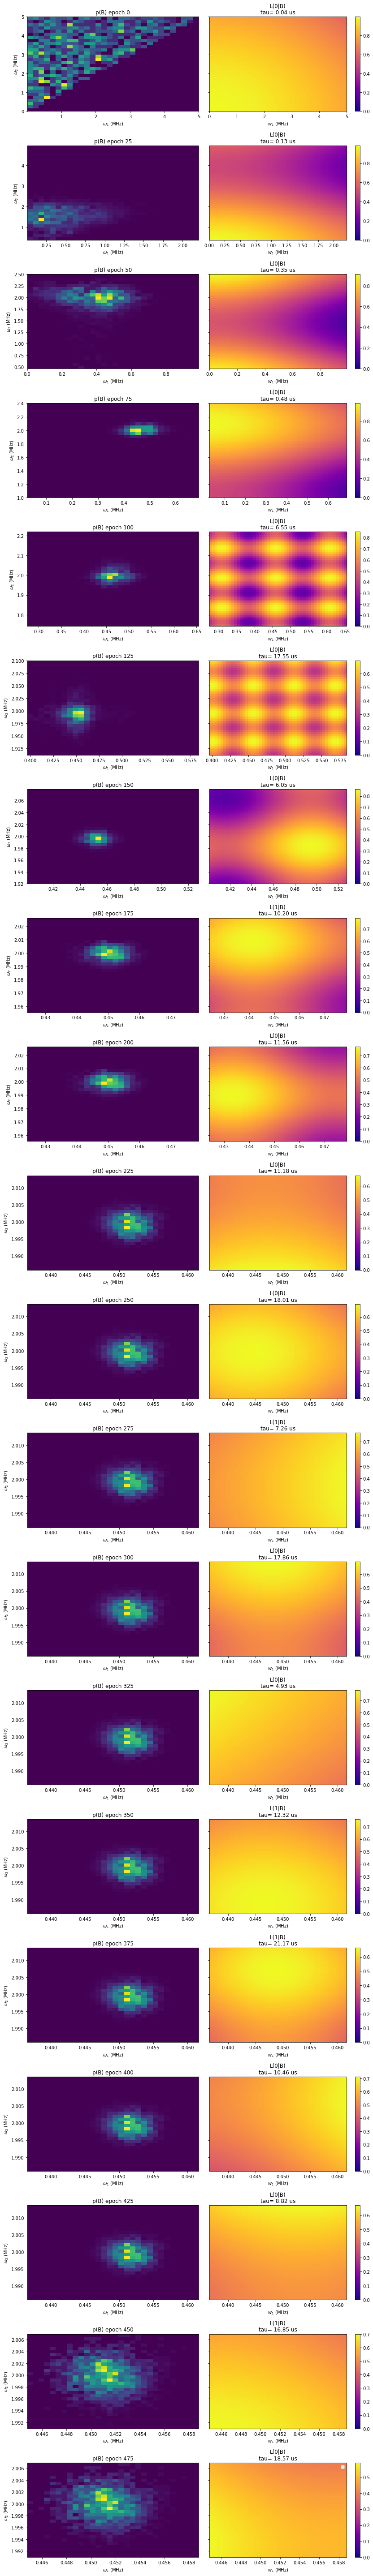

No handles with labels found to put in legend.


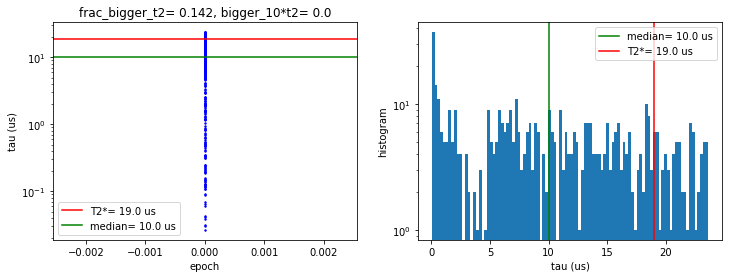

In [46]:
# run MFL
set_common_params()
reset_result()

t2star_s = 19e-6
n_epochs = 500

binarize_mode =  'majority' #'rand_coin' #

noise_mode = None #'Gauss'
noise_c = 0.0369
noise_n_rep = 1500


#run_estimation(n_epochs=n_epochs, n_sweeps=1)
print(get_params())
if run_clustered:
    run_estimation_cluster(n_epochs=n_epochs, n_sweeps=1, i_split_exp=100)
    print("Invoked cluster focus in epochs {}".format(get_idx_cluster_focused()))
else:
    run_estimation(n_epochs=n_epochs, n_sweeps=1)


save_folder = "C:/Users/Timo/Desktop/multiMFL_results"
save_folder = save_folder + '.' + str(get_file_index(save_folder))
#enable_safe(save_folder)
#save_notebook(dir())
plot_result()
plot_scaling()
#plot_clusters()
#plot_zs()
errs = get_error_zs()
plot_noise_model(n_samples=1e4, n_bins=30)

# covariance 2d
plot_priors_2d_gaussian_heatmap(epochs_idx=range(0,  n_epochs, 25), n_bins=30, plot_likelihoods=True)
#plot_priors(epochs_idx=range(0, n_epochs//10, 10), n_bins=50, always_show_err=True)
#plot_priors(epochs_idx=range(0, n_epochs//10, 1), n_bins=20)


#print("rel error= {:.2f}%. rel uncer= {:.2f}%. Error datums: {} ({:.1f} %)".format(
#    100*(track_eval[-1]-true_omega)/true_omega, 100*(track_cov[-1][0][0]/track_eval[-1]),
#    len(errs), len(errs)/n_epochs*100))
#print("in (epoch, val, val_noNoise): {}".format(errs))



plot_taus()



#reset_result()
#run_estimation(n_epochs=n_epochs, n_sweeps=1, ret_priors_list=[0, n_epochs/2, n_epochs-1])
#plot_result()
#plot_priors(n_bins=20)

In [27]:
print("sqrt(cov)= \n{} \n cov= \n{}".format(track_cov[-1], track_cov_full[-1]))

sqrt(cov)= 
[[0.00700949 0.00091342]
 [0.00091342 0.00744291]] 
 cov= 
[[ 4.91330155e-05 -8.34343407e-07]
 [-8.34343414e-07  5.53968865e-05]]


## Create tau list

4 reps with 200 epochs
[25, 91, 97, 161, 175, 335, 399, 448, 460, 482, 484, 525, 556, 701, 717, 718, 744, 821, 833, 991, 1082, 1205, 1241, 1286, 1421, 1522, 2126, 2210, 2217, 2246, 2348, 2514, 2561, 2583, 2593, 2652, 2698, 2734, 2737, 2747, 2781, 2824, 2846, 2858, 2921, 2965, 3094, 3114, 3155, 3180, 3190, 3238, 3251, 3359, 3363, 3387, 3461, 3467, 3497, 3553, 3589, 3635, 3651, 3700, 3751, 3837, 3924, 3965, 3994, 4005, 4009, 4021, 4084, 4137, 4150, 4201, 4264, 4277, 4285, 4322, 4348, 4379, 4381, 4408, 4419, 4423, 4453, 4455, 4456, 4474, 4496, 4544, 4758, 4873, 4969, 5044, 5111, 5129, 5238, 5272, 5281, 5295, 5298, 5299, 5387, 5436, 5539, 5592, 5658, 5711, 5713, 5779, 5795, 5796, 5810, 5899, 5908, 5974, 5990, 6036, 6048, 6071, 6080, 6109, 6139, 6192, 6295, 6312, 6361, 6502, 6546, 6556, 6832, 6974, 7055, 7059, 7085, 7120, 7209, 7231, 7271, 7276, 7313, 7314, 7352, 7428, 7462, 7549, 7598, 7681, 7707, 7723, 7729, 7731, 7744, 7907, 7918, 7919, 7974, 8038, 8055, 8057, 8143, 8175, 8195, 8312, 832

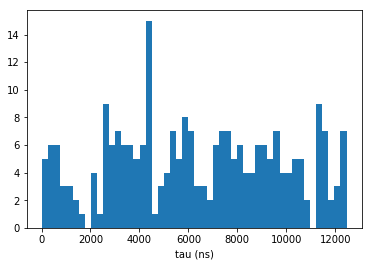

In [291]:
import random
import functools, operator
    
def create_tau_exp(n_taus_exp=245, n_epochs=150, tau_first_req_ns=25e-9):
    
    def flatten(a):
        # relatively inefficient like this
        #https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists
        try:
            return list(np.asarray(a).flatten())
        except TypeError as e:
            print("Error in {}".format(a))
            raise e
        
    global t2star_s, track_tau
    
    t2_ns = t2star_s*1e9
    tau_filter_thresh = 3*t2_ns
    n_mc = (n_taus_exp // n_epochs + 1) * 2   # monte carlo repetitions
    print("{} reps with {} epochs".format(n_mc, n_epochs))
    tau_acc = [tau_first_req_ns*1e9]
    
    for i in range(0, n_mc):
        reset_result()
        run_estimation(n_epochs=n_epochs, n_sweeps=1)
        tau_acc.extend(flatten(track_tau))
        tau_acc = flatten(tau_acc)
        #print("track_tau {} {}".format(len(track_tau), track_tau))
        #print("tau_acc {} {}".format(len(tau_acc), tau_acc))
        #print("flatten track_tau {} {}".format(len(flatten(track_tau)), flatten(track_tau)))
        
 
    taus_filter_ns = np.asarray(list(map(int, tau_acc)))   # to array of ints
    taus_filter_ns = sorted(list(set(taus_filter_ns[taus_filter_ns < tau_filter_thresh])))  # remove duplicates and filter
    taus_exp = random.sample(taus_filter_ns, k=n_taus_exp)

    print((sorted(taus_exp)))
    plt.hist(taus_exp, bins=50)
    plt.xlabel("tau (ns)")
    
    return taus_exp

noise_mode = 'Gauss'
noise_c = 0.03
noise_n_rep = 3e3
tau_list = create_tau_exp(n_epochs=200)

# Sensitivity

In [449]:
# todo: currently broken 

## Monte carlo lib

In [117]:
## Monte Carlo sensitivity without overhead

t_overhead = {'comp':0e-3, 'latency':0e-6, 't_laser':0e-9, 't_wait':0e-9, 't_mw':0e-9}   # s


def monte_carlo_mfl_runs(n_mc, n_epcohs, n_sweeps, run_clustered=False):
    """
    repeat complete mfl run
    """
    global true_omega_1, true_omega_2
    global track_cov_full
    
    b_list = []
    dB_list = []
    tau_list = []
    t_total_list = []
    err_list = []
    cov_full_list = []
    for i in range(0, n_mc):
        reset_result()
        # noise in run estimation done by sampling Gaussian
        # -> set global noise_n_rep
        try:
            if not run_clustered:
                (taus, B, dB, priors) = run_estimation(n_epochs=n_epochs, n_sweeps=1)  
            else:
                (taus, B, dB, priors) = run_estimation_cluster(n_epochs=n_epochs, n_sweeps=1, i_split_exp=100)  
        except NameError: # ApproximationError from mfl lib
            continue
        
        b_list.append(np.asarray(B))
        dB_list.append([ np.asarray([el[0,0] for el in dB]), np.asarray([el[1,1] for el in dB]) ])  # MHz rad
        tau_list.append(1e-9*np.asarray(taus)*n_sweeps)  # taus: ns -> t_phase: s
        err_list.append([np.asarray(B)[:,0] - true_omega_1, np.asarray(B)[:,1] - true_omega_2])
        cov_full_list.append(np.asarray(track_cov_full))
        
    return b_list, dB_list, tau_list, err_list, cov_full_list

def sample_db_monte_carlo_mfl(n_mc, n_epochs, n_sweeps):
    """
    samples n_mc mfl runs and gives for each sample estimates after 
    one complete mfl run.
    """
    global true_omega
    global t_overhead_dict
    
    dB_list = []
    t_phase_list = []
    t_total_list = []
    err_list = []
    for i in range(0, n_mc):
        reset_result()
        # noise in run estimation done by sampling Gaussian
        # -> set global noise_n_rep
        try:
            (taus, B, dB, priors) = run_estimation(n_epochs=n_epochs, n_sweeps=1)  
        except NameError: # ApproximationError from mfl lib
            continue
        dB_list.append(dB[-1][0][0])  # MHz rad
        t_phase_list.append(1e-9*calc_t_total_ideal(taus)*n_sweeps)  # taus: ns -> t_phase: s
        t_total_list.append(estimate_runtime(np.asarray(taus)*1e-9, t_overhead, n_sweeps=n_sweeps))
        err_list.append(B[-1] - true_omega)
    
    return dB_list, t_phase_list, t_total_list, err_list

def post_select(b, db, tau, err, full_cov, allow_err_mhz=0.05):
    n_avg = int(len(b[0])*0.05)
    err_median = np.median(np.asarray(err), axis=0)
    #print("Debug avg error over {}: {}".format(n_avg, np.average(abs(err_median[-n_avg:])/(2*np.pi))))
    #print("err_median: {}".format(err_median[-n_avg:]/(2*np.pi)))
    
    post_list = [[b[i], db[i], tau[i], err[i], full_cov[i]] for i, er in enumerate(err)\
                     if abs(np.median(er[0][-n_avg:]))/(2*np.pi) < allow_err_mhz \
                     and abs(np.median(er[1][-n_avg:]))/(2*np.pi) < allow_err_mhz]
    
    
    bs = [row[0] for row in post_list]
    dBs = [row[1] for row in post_list]
    tau_list = [row[2] for row in post_list]
    errs = [row[3] for row in post_list]
    full_covs = [row[4] for row in post_list]
    precision = len(bs) / n_mc
    
    return bs, dBs, tau_list, errs, full_covs, precision

def estimate_final_db(n_mc, n_epochs, n_sweeps):
    dBs = sample_db_monte_carlo_mfl(n_mc)
    return np.median(dBs)

def calc_sensitivitiy(db, t_total):
    return db * np.sqrt(t_total)

def calc_t_total_ideal(tau_list):
    return np.sum(tau_list)

def estimate_runtime(tau_list_s, t_overhead_dict, n_sweeps=1):
    # see SI of Santagati (2018)
    # all units: SI
    n_epochs = len(tau_list_s)
    
    t_ov = t_overhead_dict
    
    t_total = 0
    for i in range(0, n_epochs):
        t_i = n_sweeps * tau_list_s[i][0] + t_ov['comp'] + t_ov['latency'] 
        t_total += t_i
        
    t_total += n_epochs * n_sweeps * (t_ov['t_laser'] + t_ov['t_wait'] + t_ov['t_mw'])
    
    return t_total


def b_mhzrad_to_ut(b):
    gamma = 2.8 # MHz per Gauss
    b_ut = (b / (2*np.pi)) / gamma    # Gauss
    b_ut = b_ut * 100 # uT
    
    return b_ut

def est_dB_ideal(n_epochs, n_sweeps, n_mc=100):
    """
    Runs monte carlo simulation for complete MFLs.
    Returns median values over all Monte Carlo samples.
    """
    dBs, t_phases, t_totals, errs = sample_db_monte_carlo_mfl(n_mc, n_epochs, n_sweeps)
    dB_est = np.median(dBs) # MHz rad
    err = np.median(errs)   # MHz rad

    dB_est_ut = b_mhzrad_to_ut(dB_est)
    err_est_ut = b_mhzrad_to_ut(err)
    
    t_phase = np.median(np.asarray(t_phases))   #s
    t_total = np.median(np.asarray(t_totals))
    
    return t_phase, t_total, dB_est_ut, err_est_ut     #s, s, uT, uT

def plot_example_sensitivity():
    n_mc = 100
    n_epochs = 50
    n_sweeps = 1
    
    # Example run for monte carlo sensitivity estimation
    dBs, taus, _, _ = sample_db_monte_carlo_mfl(n_mc, n_epochs, n_sweeps)
    plot_hist(dBs, label='dB after {} epochs'.format(n_epochs))
    plt.show()

    dB_est = np.median(dBs) # MHz rad
    gamma = 2.8e6*2*np.pi # MHz per Gauss
    dB_est_ut = (dB_est / (2*np.pi)) / gamma    # Gauss
    dB_est_ut = dB_est_ut * 100 # uT

    t_total = np.median(np.asarray(taus))   #s
    eta = calc_sensitivitiy(dB_est_ut, t_total)   # uT/sqrt(Hz)
    print("Median {:.2f} MHz rad, T_total {:.4f} ms, sensitivity^2: {:.4f} e-3 uT^2/Hz".format(dB_est, t_total*1e3, eta**2*1e3))


def est_dB_vs_t(n_epochs_max, n_sweeps, n_mc=5):
    ts_phase = []
    ts_total = []
    dbs = []
    errs = []
    for n_epoch in range(1, n_epochs_max):
        t, t_tot, dB, err = est_dB_ideal(n_epoch, n_sweeps, n_mc=n_mc)   #s, s, uT, uT
        #eta = calc_sensitivitiy(dB, t)   # uT/sqrt(Hz)
        
        ts_phase.append(t)
        ts_total.append(t_tot)
        dbs.append(dB)
        errs.append(err)
    
    return ts_phase, ts_total, dbs, errs
       
def plot_eta_sq_vs_t(ts, etas, ax=None, color='blue', label=None):

    if ax is None:
        fig, ax = plt.subplots()
        
    ax.set(xlabel='T (ms)', ylabel='eta^2 (uT^2/Hz)')
    ax.yaxis.set_label_position("left")
    ax.set_yscale('log')
    ax.set_xscale('log')


    ax.scatter(np.asarray(ts)*1e3, np.asarray(etas)**2, color=color, label=label)
    # error

    #plt.legend()

    return ax

def plot_eta_vs_t(ts_s, etas_ntsqrthz, ax=None, color='blue', label=None):

    if ax is None:
        fig, ax = plt.subplots()
        
    ax.set(xlabel='T (ms)', ylabel='eta (nT/sqrt(Hz)')
    ax.yaxis.set_label_position("left")
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.scatter(np.asarray(ts_s)*1e3, np.asarray(etas_ntsqrthz), color=color, label=label)
    return ax
  
def plot_err_vs_t(ts, errs_uT, trueB_mhzrad, ax=None, color='red', label=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    ax.set(xlabel='T (ms)', ylabel='rel error est(B) - B')
    #ax.yaxis.set_label_position("right")
    ax.set_yscale('log')
    ax.set_xscale('log')

    # error
    rel_err = abs(np.asarray(errs_uT) / b_mhzrad_to_ut(trueB_mhzrad))
    #print("rel error {}".format(rel_err))
    ax.scatter(np.asarray(ts)*1e3, rel_err, color=color, label=label)
    ax.set_ylim([min(rel_err), max(rel_err)])
    #print("{} epochs: {} ms, {} uT^2/Hz".format(n_epoch, t*1e3, eta**2))

    #plt.legend()
    
    return ax

def plot_hor_line(value, color='green', label=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.axhline(value, color=color, label=label)
    
    return ax

def calc_stdmes_sensitivity(tau_s, t_total_s, t2star_s, c=1):
    # see Degen Reinhard 'Quantum Sensing'
    # optimal choice: tau = t2star / 2
    
    gamma = 2*np.pi*2.8e6 # -> Hz (rad) per Gauss
    t_m = t_total_s - tau_s
    
    decay = np.exp(tau_s/t2star_s)
    #print("decay f= {} tau: {}, t2*: {}".format(decay, tau_s, t2star_s))
    eta = decay*np.sqrt(tau_s + t_m)/(gamma*c*tau_s) # Gauss / sqrt(Hz)
        
    return 100*eta  # -> uT / sqrt(Hz)   

def calc_stdmes_sensitivity_opt(t2star_s, c=1):
     # Degen17, at optimum, t_m=0
    
    gamma = 2*np.pi*2.8e6 # -> Hz (rad) per Gauss
    eta = np.sqrt(2*np.exp(1))/(gamma*c*np.sqrt(t2star_s))
    
    # difference between Degen and Rondin: sqrt(2e) in numerator
    # comes from: there is decoherence, take ~T2* (Rondin)
    # vs. optimized exp(-tau/T2*) -> T2*/2 (Degen)
    #eta = 1/(gamma*c*np.sqrt(t2star_s))
    
    return 100*eta  # -> uT / sqrt(Hz)   

def calc_stdmes_sensitivity_opt_2(t2star_s, c=1):
    # Rondin17, with C*sqrt(I*t_l) = c from Degen17
    hbar = 6.63e-34 / (2*np.pi)
    mu = 9.274e-24
    g = 2
    
    return 1e6 * hbar / (g*mu*c*np.sqrt(t2star_s))    # -> uT / sqrt(Hz)   
    

def estimate_precision(n_mc, n_epochs, tolerate_rel_err=10e-2):
        
    n_sweeps = 1
    dB_list, t_phase_list, t_total_list, err_list = sample_db_monte_carlo_mfl(n_mc, n_epochs, n_sweeps)
    rel_error_list = np.asarray(err_list) / true_omega
    big_errors = rel_error_list[abs(rel_error_list) > tolerate_rel_error]
    
    return 1-len(big_errors)/float(n_mc), big_errors


def calc_tau_ramsey_bmax(b_max_mhz):
    
    gamma = 2*np.pi*2.8e6 # Hz (rad) per Gauss
    b_max_t = b_max_mhz *1e6 / (gamma / 2*np.pi)
    
    tau_s = 1 / (2*np.pi*gamma*b_max_t) # Waldherr 2012
    
    return tau_s

def calc_rolling_mean(x, y, rolling_window=None, subsampling_fraction=20):
    # shadows setup3 mfl_analysis_snippets.py

    # to pandas for a time series (data is unevenly spaced!)
    data_zip = zip(x, y)
    data_zip = sorted(data_zip, key = lambda x: x[0])

    eta_series = pd.DataFrame(data_zip, columns=['x', 'y'])
    eta_series.set_index(pd.DatetimeIndex(eta_series['x']))

    eta_series['date'] = pd.to_datetime(eta_series['x'], unit='s')
    eta_series.set_index('date', inplace=True)
    #print(eta_series[-10:])
    dt_window = rolling_window
    eta_mean = eta_series.rolling(dt_window, min_periods=1).median()
    eta_std_dev = eta_series.rolling(dt_window, min_periods=1).std()#

    # subsampling on right 3/4 of data
    if len(eta_mean) > 10e3:
        n_skip = int(len(eta_mean) / 10e3)
        n_split = int(len(eta_mean) / subsampling_fraction)
        eta_mean = pd.concat([eta_mean[0:n_split], eta_mean[n_split::n_skip]])
        eta_std_dev = pd.concat([eta_std_dev[0:n_split], eta_std_dev[n_split::n_skip]])

    x = np.asarray(eta_mean['x'].tolist())
    y = np.asarray(eta_mean['y'].tolist())
    dy = np.asarray(eta_std_dev['y'].tolist())
    #print(dy[-10:])

    return x, y, dy

def save_avg_mfl(resdict, savedir, global_vars):
    """
    global_vars: get vars in global scope by "dir()"
    """
    today = date.today()
    date_str = date.today().strftime("%Y%m%d")
    save_folder = savedir
    save_folder = save_folder + '_' + date_str + '.' + str(get_file_index(save_folder))
    enable_safe(save_folder)
      
    taus_median = resdict['taus_median']
    taus_tot = resdict['taus_tot']
    dBs_median_mhz = resdict['dBs_median_mhz']
    
    if mov_avg_t_window == None:
        print("Debug: Saving to {}".format(save_folder + "/taus_median.txt"))
        np.savetxt(save_folder + "/taus_median.txt", taus_median)
        np.savetxt(save_folder + "/taus_tot.txt", taus_tot)
        np.savetxt(save_folder + "/dBs_median.txt", dBs_median_mhz)

    else:
        print("Debug: Saving to {}".format("/taus_median_t_window={}.txt".format(mov_avg_t_window)))
        np.savetxt(save_folder + "/taus_median_t_window={}.txt".format(mov_avg_t_window), taus_median)
        np.savetxt(save_folder + "/taus_tot_t_window={}.txt".format(mov_avg_t_window), taus_tot)
        np.savetxt(save_folder + "/dBs_median_t_window={}.txt".format(mov_avg_t_window), dBs_median_mhz)
        
    print("Debug: Start big save")
    save_notebook(global_vars)
        
def average_sim(bs, dBs, taus, t_ov=None, mov_avg_t_window=None):
    
    tau_list = taus
    
    if mov_avg_t_window == None:
        dBs_median_mhz = np.median(dBs, axis=0).transpose()/(2*np.pi)  # MHz
        taus_median = np.median(tau_list, axis=0).flatten()
        taus_tot = calc_total_runtime(taus_median)*noise_n_rep
        covs_median = np.median(np.asarray(covs), axis=0)/(2*np.pi)  # MHz

    else:
        taus_tot = [calc_total_runtime(taus)*noise_n_rep for taus in tau_list]
        taus_tot = (np.asarray(taus_tot)).flatten()
        dBs_median_mhz_1 = (np.asarray(dBs)[:,0,:]/(2*np.pi)).flatten()
        taus_tot_median, dBs_median_mhz_1, ddBs_mhz_1 = calc_rolling_mean(taus_tot, 
                                                           dBs_median_mhz_1, 
                                                           rolling_window=mov_avg_t_window)
        dBs_median_mhz_2 = (np.asarray(dBs)[:,1,:]/(2*np.pi)).flatten()
        _, dBs_median_mhz_2, ddBs_mhz_2 = calc_rolling_mean(taus_tot, 
                                                           dBs_median_mhz_2, 
                                                           rolling_window=mov_avg_t_window)
        taus_tot = taus_tot_median
        dBs_median_mhz = np.zeros([dBs_median_mhz_2.shape[0], 2])
        dBs_median_mhz[:,0] = dBs_median_mhz_1
        dBs_median_mhz[:,1] = dBs_median_mhz_2

        # reverse time accumulation
        taus_median = taus_tot_median/noise_n_rep
        taus_median[1:] -= taus_median[:-1].copy()
        
    
    # todo: b_median not working (see 1d mfl)
        
    return None, dBs_median_mhz, taus_tot, taus_median, ddBs_mhz_1, ddBs_mhz_2
     


## Standard mes limit

In [23]:
# Taylor 08: C=0.05, T2*=1e-6 => ~ 1 uT/sqrt(Hz)
#            C=0.3            => ~ 120 nT/sqrt(Hz)
# t_m = 0
# -> x4 bigger than here
# t_m = 5e-6
# -> fits roughly
t2star = 19e-6  #17.1e-6
tau = t2star/2 
t_total = tau + 0.6e-6 + 1e-6  # laser + wait
C = 0.018
eta = 1000*calc_stdmes_sensitivity(tau, t_total, t2star, c=C)
eta_opt = 1000*calc_stdmes_sensitivity_opt(t2star, c=C)
eta_opt_2 = 1000*calc_stdmes_sensitivity_opt_2(t2star, c=C)

print("T2*= {}, C= {} \n => SMS (opt) eta= {:.1f} ({:.1f}) nT/sqrt(Hz), eta^2= {:.1f} nT^2/Hz".format(
        t2star, C, eta, eta_opt, eta**2))
print("Rondin14 SMS: eta= {:.1f} nT/sqrt(Hz)".format(eta_opt_2))

T2*= 1.9e-05, C= 0.018 
 => SMS (opt) eta= 182.6 (168.9) nT/sqrt(Hz), eta^2= 33338.8 nT^2/Hz
Rondin14 SMS: eta= 72.5 nT/sqrt(Hz)


## Ramsey sensitivity vs B_max

## Ideal sensitivity

T2*= 1.35e-05, C= 0.021 
 => SMS (opt) eta= 191.0 (171.8) nT/sqrt(Hz), eta^2= 36497.2 nT^2/Hz
Rondin14 SMS: eta= 73.7 nT/sqrt(Hz)


## Averaged multiple MFL runs

Allow err in post selection: 0.04499999999632649 MHz
Post selecting 250 -> 217, p= 0.868
{'mfl_res_a': 0.98, 'mfl_res_th': 0.5, 'true_omega_1': 2.827433388, 'true_omega_2': 3.39292, 'freq_min': 0, 'freq_max': 31.41592653589793, 't2star_s': 1.9e-05, 'n_particles': 2000, 'noise_mode': 'Gauss', 'noise_c': 0.0364, 'noise_n_rep': 1500.0, 'noise_photons_0': 0.04, 'noise_photons_1': 0.032, 'binarize_mode': 'majority', 'exp_mode': 'ramsey', 'hahn_b_gauss': 10, 'clusered': False}


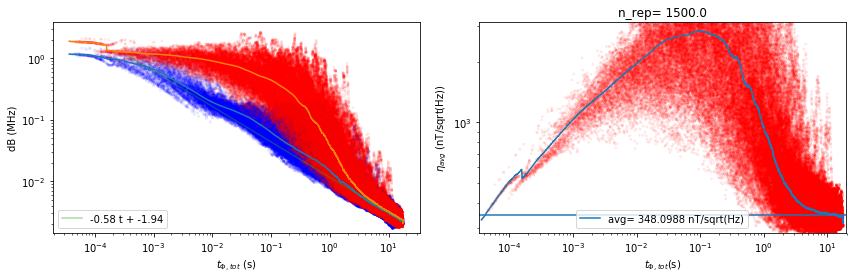

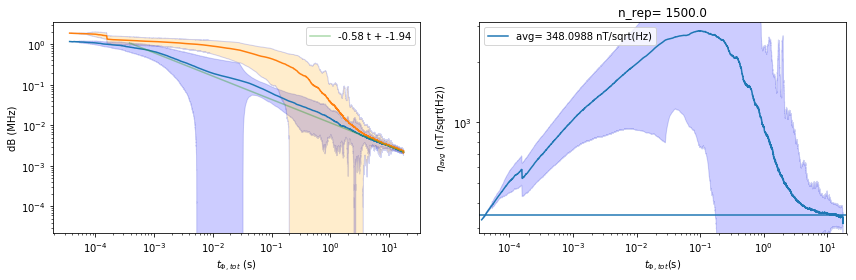

No handles with labels found to put in legend.


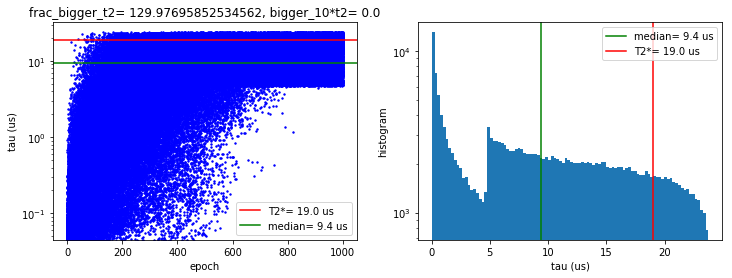

In [96]:
set_common_params()

true_omega_1 =  2.827433388 #2*np.pi*0.4 
true_omega_2 =  3.39292#2*np.pi*0.54
true_params = np.asarray([[true_omega_1, true_omega_2]])

t2star_s = 19e-6
t_overhead = {'comp':0e-3, 'latency':0e-6, 't_laser':0e-9, 't_wait':0e-9, 't_mw':0e-9}   # s
n_sweeps = 1  # deprecated
run_clustered = False

exp_mode = 'ramsey'

# monte carlo params
n_epochs = 1000#1500
n_mc = 250  # 500
mov_avg_t_window = '100ms'

# noise params
noise_mode = 'Gauss'
noise_c = 0.0364
noise_n_rep = 1.5e3


allow_err_mhz = true_omega_1/(2*np.pi)*0.1

print("Allow err in post selection: {} MHz".format(allow_err_mhz))
#"""
#bs, dBs, tau_list, errs, covs = monte_carlo_mfl_runs(n_mc, n_epochs, n_sweeps, run_clustered=run_clustered)
#bs, dBs, tau_list, errs, covs, precision = post_select(bs, dBs, tau_list, errs, covs, allow_err_mhz=allow_err_mhz)
#"""
print("Post selecting {} -> {}, p= {}".format(n_mc, len(bs), precision))

_, dBs_median_mhz, taus_tot, taus_median, ddB1, ddB2 = average_sim(bs, dBs, tau_list, t_ov=None, mov_avg_t_window=mov_avg_t_window)


print(get_params())

# with scatter
plot_scaling(taus_median, dBs_median_mhz, n_rep=noise_n_rep,
             taus_scatter=tau_list, dB_mhz_scatter=np.asarray(dBs)/(2*np.pi))
# with d(dB) by pandas rolling_mean.std
plot_scaling(taus_median, dBs_median_mhz, n_rep=noise_n_rep,
             taus_scatter=tau_list, ddB1=ddB1, ddB2=ddB2)

plot_taus(np.asarray(tau_list)*1e9)

In [102]:
dBs_median_mhz[-50,0]

0.0022773498191798066

In [151]:
save = True

if save:
    resdict = {"taus_median":taus_median, "taus_tot": taus_tot, 
              "dBs_median_mhz": dBs_median_mhz}
    save_avg_mfl(resdict, "C:/Users/Timo/Desktop/multiMFL_results" , dir())  
    

Save enabled to C:/Users/Timo/Desktop/multiMFL_results_20200518.31
Debug: Saving to /taus_median_t_window=100ms.txt
Debug: Start big save


Debug

In [64]:
print(get_params())
err_median = np.median(np.asarray(errs), axis=0)
bs_median = np.median(np.asarray(bs), axis=0)
#plt.plot(bs_median[:,0]/(2*np.pi))
#plt.plot(bs_median[:,1]/(2*np.pi))
err_median[1,:].size

{'mfl_res_a': 0.98, 'mfl_res_th': 0.5, 'true_omega_1': 2.5132741228718345, 'true_omega_2': 12.566370614359172, 'freq_min': 0, 'freq_max': 31.41592653589793, 't2star_s': 1.9e-05, 'n_particles': 2000, 'noise_mode': 'Gauss', 'noise_c': 0.0364, 'noise_n_rep': 1500.0, 'noise_photons_0': 0.04, 'noise_photons_1': 0.032, 'binarize_mode': 'majority', 'exp_mode': 'ramsey', 'hahn_b_gauss': 10}


1500

In [113]:
print("Full cov (not sqrt):")
covs_median = np.median(np.asarray(covs), axis=0)/(2*np.pi)  # MHz
print(np.asarray(covs).shape)
print(" -> (medianing)")
print(covs_median.shape)
print(covs_median[-1])
print("Sqrt(abs(cov))")
print(np.sqrt(abs(covs_median[-1])))


Full cov (not sqrt):
(48, 1000, 2, 2)
 -> (medianing)
(1000, 2, 2)
[[3.93261350e-05 1.26699875e-06]
 [1.26699875e-06 3.53361069e-05]]
Sqrt(abs(cov))
[[0.00627106 0.00112561]
 [0.00112561 0.00594442]]


## Averaged MFL, optimize resampling 

In [147]:
import itertools

set_common_params()
save = True

#freq_max = 2*np.pi*6.67  # for paper fig 2
t2star_s = 19.0e-6
t_overhead = {'comp':1e-3, 'latency':0e-6, 't_laser':750e-9, 't_wait':1e-6, 't_mw':0e-9}   # s
run_clustered = True

# monte carlo params
n_epochs = 1000 #1500
n_mc = 10
mov_avg_t_window = '100ms'

# noise params
noise_mode = None
noise_mode = 'Gauss'
noise_c = 0.0364
noise_n_rep = 1500 #500

"""
noise_mode = 'Poiss' #'Gauss'
noise_n_rep = 150
noise_phot_0 = 0.0699
noise_phot_1 = 0.0503979
"""

# post selection
allow_err_mhz = true_omega_1/(2*np.pi)*0.1

print(get_params())
print("Allow err in post selection: {} MHz".format(allow_err_mhz))

db_meds = []
t_tots = []

mfl_a = list(reversed(np.linspace(0.7,0.999,8)))
mfl_th = list(np.linspace(0.2,0.8,8))

str_progress = display("Start running",display_id=True)

n_sims = len(mfl_a)*len(mfl_th)
i = 0
for a in mfl_a:
    for th in mfl_th:
        
        str_progress.update("[{:.1f}%] th= {:.2f}, a= {:.2f}".format(100*i/n_sims, th, a))
        
        mfl_res_a = a
        mfl_res_th = th
        #print(get_params())
        #"""
        bs, dBs, tau_list, errs, covs = monte_carlo_mfl_runs(n_mc, n_epochs, n_sweeps, run_clustered=run_clustered)
        bs, dBs, tau_list, errs, covs, precision = post_select(bs, dBs, tau_list, errs, covs, allow_err_mhz=allow_err_mhz)
        #"""

        _, dBs_median_mhz, taus_tot, taus_median, _, _ = average_sim(bs, dBs, tau_list, t_ov=None, mov_avg_t_window=mov_avg_t_window)

        db_meds.append(dBs_median_mhz)
        t_tots.append(taus_tot)
        i += 1






{'mfl_res_a': 0.98, 'mfl_res_th': 0.5, 'true_omega_1': 2.827433388230814, 'true_omega_2': 12.566370614359172, 'freq_min': 0, 'freq_max': 31.41592653589793, 't2star_s': 1.9e-05, 'n_particles': 2000, 'noise_mode': 'Gauss', 'noise_c': 0.0364, 'noise_n_rep': 1500, 'noise_photons_0': 0.04, 'noise_photons_1': 0.032, 'binarize_mode': 'majority', 'exp_mode': 'ramsey', 'hahn_b_gauss': 10, 'clusered': True}
Allow err in post selection: 0.045000000000000005 MHz


'[98.4%] th= 0.80, a= 0.70'

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_bas

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_bas

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_bas

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_bas

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_bas

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_bas

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_bas

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_bas

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_bas

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_bas

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_bas

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_bas

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_bas

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_bas

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_bas

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_bas

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_bas

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_bas

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_bas

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_bas

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_bas

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_bas

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_bas

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:474: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\numpy\lib\function_bas

What about clustering? 

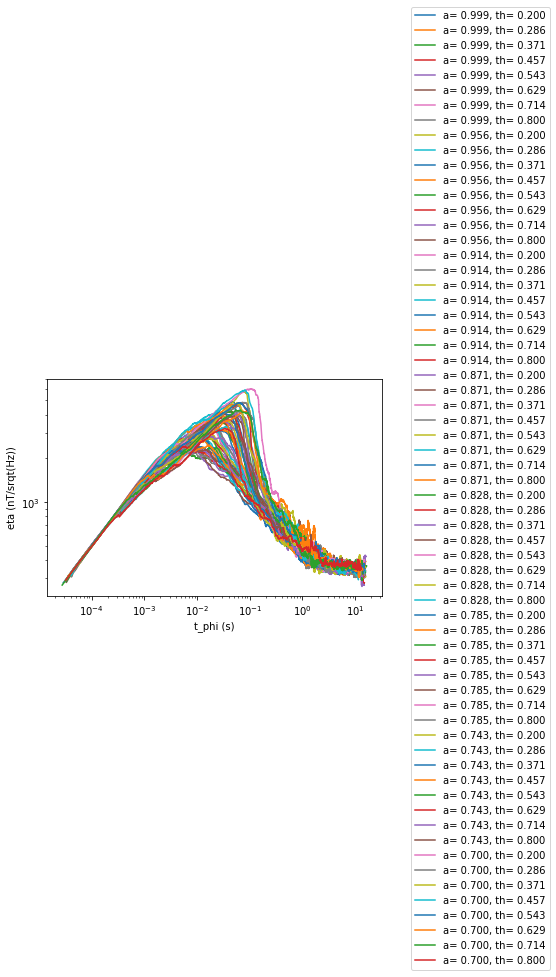

In [149]:
fig = plt.figure()

i=0
for a in mfl_a:
    for th in mfl_th:
        t_i = []
        dB_avg_i = []
        try:
            dB_row = db_meds[i]
            dB_avg_i = (np.asarray(dB_row)[:,0]+ (np.asarray(dB_row)[:,1]))/2
            dB_avg_i = dB_avg_i / 2.8 *1e5
            t_i = np.asarray(t_tots[i])
        except IndexError:
            break
        i += 1
        
        plt.plot(t_i, np.sqrt(t_i)*dB_avg_i, label="a= {:.3f}, th= {:.3f}".format(
                                                a, th))

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

plt.ylabel("eta (nT/srqt(Hz))")
plt.xlabel("t_phi (s)")
plt.legend(bbox_to_anchor=(1.3, 0.5), loc="right",  bbox_transform=fig.transFigure)
plt.show()

## Experimental sensitivity

# Noise

## Precision vs n_sweeps

## Precision vs freq_max